### 6.6 Model CatBoost (handle missing value and categorical variables)

In [1]:
import os
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
# import datetime
import seaborn as sns
sns.set()
import matplotlib.pyplot as plt
import numpy as np
# from scipy import stats
# import random
import category_encoders as ce
from category_encoders import LeaveOneOutEncoder, TargetEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split 
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn import model_selection

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
import xgboost as xgb
from catboost import CatBoostClassifier
import lightgbm as lgb

import time
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn import metrics
from sklearn.metrics import f1_score
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_fscore_support as score, accuracy_score
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from imblearn.over_sampling import SMOTE

from tabulate import tabulate
%matplotlib inline

In [2]:

print(os.getcwd())
os.chdir('/Users/liuyang/Desktop/Springboard_Capstone') 
print(os.getcwd())

/Users/liuyang/Desktop/Springboard_Capstone/notebooks
/Users/liuyang/Desktop/Springboard_Capstone


In [3]:
df = pd.read_csv('data/train.csv')

In [4]:
df.head()

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
0,23798,city_149,0.689,Male,Has relevent experience,no_enrollment,Graduate,STEM,3,100-500,Pvt Ltd,1,106,0
1,29166,city_83,0.923,Male,Has relevent experience,no_enrollment,Graduate,STEM,14,<10,Funded Startup,1,69,0
2,46,city_16,0.910,NaN,Has relevent experience,no_enrollment,Graduate,STEM,6,50-99,Public Sector,2,4,0
3,18527,city_64,0.666,Male,Has relevent experience,no_enrollment,Graduate,STEM,14,50-99,Pvt Ltd,1,26,0
4,21751,city_100,0.887,NaN,No relevent experience,no_enrollment,Masters,STEM,8,NaN,NaN,2,88,1


In [5]:
df.shape

(18359, 14)

In [6]:
X = df.drop(['target','enrollee_id'],axis=1)
y = df['target']

In [7]:
cat_features = X.select_dtypes(include=['object']).columns.tolist()
cat_features

['city',
 'gender',
 'relevent_experience',
 'enrolled_university',
 'education_level',
 'major_discipline',
 'experience',
 'company_size',
 'company_type',
 'last_new_job']

In [8]:
for i in cat_features:
    X[i].fillna('None', inplace =True)

In [9]:
# X[cat_features].isnull().sum()

In [10]:
cat_features_indices = []
cat_features
for i, j in enumerate(X.columns):
    if j in cat_features:
        cat_features_indices.append(i)

In [11]:
X_train,X_test,y_train,y_test = train_test_split(X.to_numpy(), y.ravel(), test_size=0.30, stratify=y, random_state=43)

In [12]:
y_test.sum()

728

In [13]:
def trainmodel_cv(model, n):
    
    cv = KFold(n_splits=n)
    for i, (train, test) in enumerate(cv.split(X_train, y_train)):
        X_train_fold, y_train_fold = X_train[train], y_train[train]
        X_test_fold, y_test_fold = X_train[test], y_train[test]
        model.fit(X_train_fold, y_train_fold, cat_features = cat_features_indices, silent=True)
    
    return model

In [24]:
import scikitplot as skplt 

def liftcurve_probahisto_score(trainmethod, model, model_name, n, Xtest, ytest, ylim1, ylim2, xlim):
    
    # replace trainmethod with trainmodel_cv or trainmodel_os_cv
    final_model = trainmethod(model, n)
    
    # get prediction from test dataset
    yfinal = final_model.predict(Xtest)
    yfinal_proba = final_model.predict_proba(Xtest)[:,1]
    y_probas = final_model.predict_proba(Xtest)
    
    figure, (ax1,ax2) = plt.subplots(1,2, figsize=(16,4))
    skplt.metrics.plot_lift_curve(y_true=ytest, y_probas=y_probas, ax=ax1)
    ax1.set_ylim([0, ylim1])
    ax1.set_xlabel('Percentage of sample', fontsize=12)
    ax1.set_ylabel('Lift', fontsize=12)

    
    predProba_label = pd.DataFrame()
    predProba_label['proba'] = yfinal_proba
    predProba_label['label'] = ytest
    percent20 = round(len(ytest)*0.2)
    percent50 = round(len(ytest)*0.5)
    Target_in_top20pct = round(predProba_label,4).sort_values('proba', ascending=False).nlargest(percent20,'proba').label.sum()
    Target_in_top50pct = round(predProba_label,4).sort_values('proba', ascending=False).nlargest(percent50,'proba').label.sum()
    
    
    weights_1 = np.ones_like(predProba_label[predProba_label['label']==1].proba.index)/len(predProba_label[predProba_label['label']==1].proba.index)
    predProba_label[predProba_label['label']==1].proba.plot(kind='hist',
                                                                      bins=10,
                                                                      color='r',
                                                                      label='positive',
                                                                      histtype='step',
                                                                      stacked=False,
                                                                      lw=2,
                                                                      weights=weights_1,
                                                                      ax=ax2)


    weights_2 = np.ones_like(predProba_label[predProba_label['label']==0].proba.index)/len(predProba_label[predProba_label['label']==0].proba.index)
    predProba_label[predProba_label['label']==0].proba.plot(kind='hist',
                                                                     bins=10,
                                                                     label='negative',
                                                                     histtype='step',
                                                                     stacked=False,
                                                                     lw=2,
                                                                     weights=weights_2,
                                                                     ax=ax2)
    

    ax2.set_xlabel('Probability of prediction', fontsize=12)
    ax2.set_ylabel('Fraction of observation', fontsize=12)
    ax2.set_ylim([0, ylim2])
    ax2.set_xlim([0, xlim])
    ax2.legend()
    ax2.set_title('Predicted probability vs class',fontsize=12)
    
    #plt.suptitle(model,fontsize=12,fontweight='bold')
    precision, recall, f1score, support = score(ytest, yfinal, pos_label=1,average='binary')
    roc_auc = roc_auc_score(ytest, yfinal_proba)
    dataframe = pd.DataFrame([precision, recall, f1score, roc_auc, Target_in_top20pct, Target_in_top50pct],
                       index=['precison','recall','f1score','roc_auc', 'Target_in_top20pct', 'Target_in_top50pct'], 
                       columns=[model_name]).T
    
    return round(dataframe, 3)

,precison,recall,f1score,roc_auc,Target_in_top20pct,Target_in_top50pct
CatB,0.808,0.012,0.024,0.73,795.0,1297.0


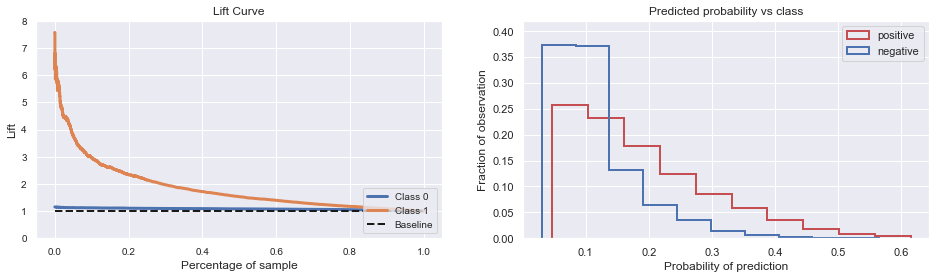

In [15]:
liftcurve_probahisto_score(trainmodel_cv, CatBoostClassifier(), 'CatB', 5, X_train, y_train, 8, 0.42)

,precison,recall,f1score,roc_auc,Target_in_top20pct,Target_in_top50pct
CatB,0.5,0.005,0.011,0.662,275.0,514.0


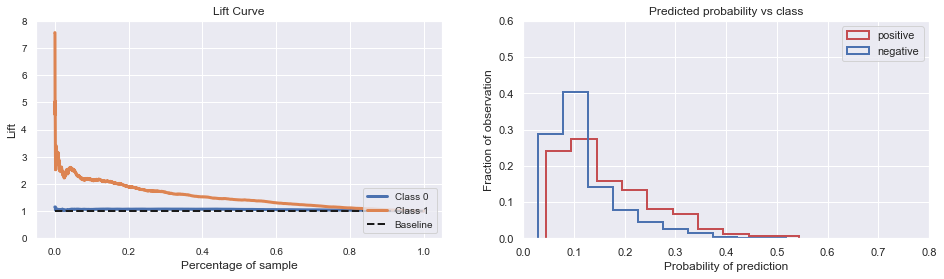

In [27]:
liftcurve_probahisto_score(trainmodel_cv, CatBoostClassifier(), 'CatB', 5, X_test, y_test, 8, 0.6, 0.8)

# 7 Hyper Parameter Tuning

In [28]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform as sp_randFloat
from scipy.stats import randint as sp_randInt  

parameters = {'depth'         : sp_randInt(4, 10),
              'learning_rate' : sp_randFloat(),
              'iterations'    : sp_randInt(900, 1200)
                 }
    
randm = RandomizedSearchCV(estimator=CatBoostClassifier(silent=True), param_distributions = parameters, 
                           cv = 3)
randm.fit(X_train, y_train,cat_features= cat_features_indices)

# Results from Random Search
print("\n========================================================")
print(" Results from Random Search " )
print("========================================================")    

print("\n The best estimator across ALL searched params:\n",
      randm.best_estimator_)

print("\n The best score across ALL searched params:\n",
      randm.best_score_)

print("\n The best parameters across ALL searched params:\n",
      randm.best_params_)

KeyboardInterrupt: 

,precison,recall,f1score,roc_auc,Target_in_top20pct,Target_in_top50pct
CatB,0.833,0.007,0.014,0.659,276.0,503.0


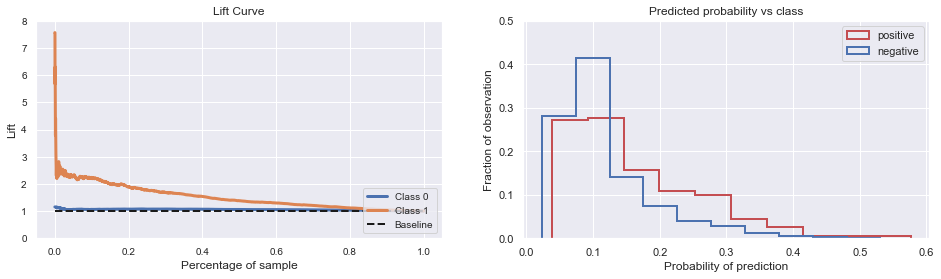

In [23]:
liftcurve_probahisto_score(trainmodel_cv, 
                           CatBoostClassifier(iterations=1182,  depth=7, learning_rate=0.027516), 
                           'CatB', 5, X_test, y_test, 8, 0.5)

In [19]:
# get feature importance for catboost on train dataset
from catboost import Pool
train_pool = Pool(X_train, y_train, cat_features=cat_features_indices)
feature_names = X.columns
model = trainmodel_cv(CatBoostClassifier(iterations=939,  depth=4, learning_rate=0.014877, silent=True), 5)
feature_importances  = model.get_feature_importance(train_pool)

feature_df = pd.DataFrame(sorted(zip(feature_importances, feature_names), reverse=True), columns=['Feature Importance', 'Variable'])


KeyboardInterrupt: 

In [ ]:
plt.figure(figsize=(6,6))
g = sns.barplot('Feature Importance', 'Variable', data=feature_df)
g.set_xlabel('Feature Importance',fontsize=12,weight='bold')
g.set_ylabel('Variable',size=12,weight='bold')
g.set_yticklabels(g.get_yticklabels(),size=14)
plt.show()

In [ ]:
shap_values = model.get_feature_importance(Pool(X_train, label=y_train,cat_features=cat_features_indices), 
                                                                     type="ShapValues")
shap_values = shap_values[:,:-1]

# shap value for features
import shap
shap.initjs()

X_train_df = pd.DataFrame(X_train)
X_train_df.columns = X.columns


shap.summary_plot(shap_values, X_train_df)